In [1]:
from sat_initial import *

In [2]:
from datastructures.api import (edges_no_param, addobj, addineq, OPT, SolverRef, merge, 
copy_dicts, setsolvefor, var_params)
from datastructures.graphutils import flatten_tree, all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate, invert_edges
from datastructures.rendering import render_incidence
from datastructures.runpipeline import (model_to_problem, order_from_tree, 
    default_solver_options, mdao_workflow)
from datastructures.postprocess import print_outputs, print_inputs, update_varval
from datastructures.transformations import transform_components
import openmdao.api as om
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

### Configuration

In [4]:
run_optimal_structure = False
# global run_optimal_structure
# def f(optimal_structure):
#     global run_optimal_structure
#     run_optimal_structure=optimal_structure
# interact(f, optimal_structure=True);

### Load structure of model

In [5]:
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

### Restructure design model

We force variables from the constraints to be inputs: $L_t, X_r, EN, h, m_s$

In [6]:
not_input = {'H_{val}', r'\rho_{val}', 'm_p'}#['m_p']#'d', r'\rho_{val}', 'L_p', 'H_{val}']
not_output = {'L_t','X_r','EN', 'h', 'm_s'}#['h']#[r'm_{rz}', 'm_{r0}']
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


### Build structure of optimization model

In [7]:
outset_opt = None
if run_optimal_structure:
    outset_opt = {right:left for left, right in edges_left_right if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [8]:
tree_for_reformulation = flatten_tree(tree, 'opt')
not_outputs = var_params(model, edges)
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', solveforvars=False, mdf=True) # For OPT do not have subproblems so no need to set mdf=True/False
edges_minassign_noparam = edges_no_param(model, edges_minassign)

In [9]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [10]:
newcomps

[(('m_t', 'm_s', '\\eta_S'), 19, (None,), '-\\eta_S*m_t + m_s'),
 (('m_A', 'm_s', 'm_t', 'm_b', 'm_p', 'm_{pr}', 'm_T'), 20, (None,), '-m_A - m_T - m_b - m_p - m_s + m_t - m_{pr}')]

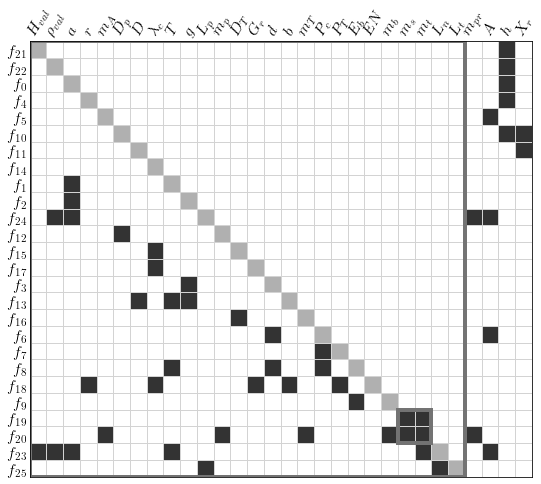

In [11]:
_, ax = render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

### Optimization formulation

In [12]:
opt = addsolver(m, name="opt", idbyname=True)

In [13]:
ENreq = Par('EN_r', 14.125)
addineq(opt, -Lt+L_min)
addineq(opt, -EN+ENreq)
addobj(opt, mt)

In [14]:
solvefor_init = [A,m_pr]
varoptions_init = {A:[0,10], m_pr:[0,10]}

In [15]:
solvefor_opt = [m_s, Lt, EN]
varoptions_opt = {}

In [16]:
solvefor, varoptions = ((solvefor_init, varoptions_init), (solvefor_opt, varoptions_opt))[run_optimal_structure]
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT}#, 'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}

In [17]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)
edges_ma_opt_noparam = edges_no_param(model, edges_ma_opt)

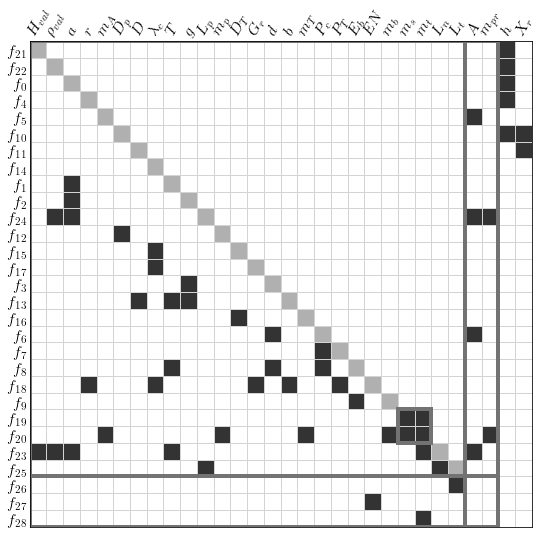

In [18]:
_, ax = render_incidence(edges_ma_opt_noparam, tree_ma_opt, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

In [24]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [25]:
#prob.set_val('L_t', 10)
prob.set_val('h', 400)
#prob.set_val('EN', 14.125)
prob.set_val('X_r', 5)

In [26]:
prob.run_model()


==
s2
==
NL: Newton Converged in 1 iterations


In [28]:
print_inputs(model, prob, namingfunc, ['m_A','m_p', 'm_T', 'm_b', 'm_s','m_{pr}'])

$$m_p$$,0.022,kg
$$m_{pr}$$,0.5,kg
$$m_T$$,0.049,kg
$$m_b$$,0.228,kg
$$m_A$$,0.5,kg
$$m_s$$,0.324,kg


In [29]:
print_outputs(model, prob,namingfunc)

$$a$$,6778,km
$$T$$,92.558,min
$$g$$,0.11,
$$d$$,0.61,
$$r$$,2293.992,km
$$m_A$$,0.5,kg
$$P_c$$,12.506,W
$$P_T$$,0.506,W
$$E_b$$,113.874,kJ
$$m_b$$,0.228,kg
$$D_p$$,0.049,m


In [27]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals']);

----------------
Design Variables
----------------
name  val     size  lower  upper  
----  ------  ----  -----  ----- 
A     [0.05]  1     0.0    10.0   
m_pr  [0.5]   1     0.0    10.0   

-----------
Constraints
-----------
name   val            size  lower   upper  equals  
-----  -------------  ----  ------  -----  ------ 
neq26  [8.57089077]   1     -1e+30  0.0    None    
neq27  [13.04126573]  1     -1e+30  0.0    None    

----------
Objectives
----------
name   val           size  
-----  ------------  ---- 
obj28  [1.62249245]  1     



In [23]:
prob.run_driver()


==
s2
==
NL: Newton Converged in 1 iterations

==
s2
==
NL: Newton Converged in 0 iterations

==
s2
==
NL: Newton Converged in 1 iterations

==
s2
==
NL: Newton Converged in 1 iterations

==
s2
==
NL: Newton Converged in 1 iterations

==
s2
==
NL: Newton Converged in 1 iterations

==
s2
==
NL: Newton Converged in 1 iterations

==
s2
==
NL: Newton Converged in 1 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [8.4486165]
            Iterations: 3
            Function evaluations: 7
            Gradient evaluations: 3
Optimization Complete
-----------------------------------


False

In [27]:
#print_inputs(model, prob, namingfunc, ['m_t','EN', 'L_t'])
print_inputs(model, prob, namingfunc, ['m_A','m_p', 'm_T', 'm_b', 'm_s','m_{pr}'])

$$m_T$$,0.049,kg
$$m_p$$,0.022,kg
$$m_s$$,1.69,kg
$$m_b$$,0.339,kg
$$m_{pr}$$,5.607,kg
$$m_A$$,0.743,kg


In [29]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals']);

----------------
Design Variables
----------------
name  val           size  lower   upper  
----  ------------  ----  ------  ----- 
m_s   [1.68972331]  1     -1e+30  1e+30  
m_t   [8.44861656]  1     -1e+30  1e+30  
A     [0.0743458]   1     0.0     10.0   
m_pr  [5.60654755]  1     0.0     10.0   

-----------
Constraints
-----------
name   val                size  lower   upper  equals  
-----  -----------------  ----  ------  -----  ------ 
eq19   [3.52111673e-10]   1     0.0     0.0    None    
eq20   [3.4994132e-09]    1     0.0     0.0    None    
neq26  [-4.26893276e-08]  1     -1e+30  0.0    None    
neq27  [8.31252471e-08]   1     -1e+30  0.0    None    

----------
Objectives
----------
name   val           size  
-----  ------------  ---- 
obj28  [8.44861656]  1     

